**Imports:**

In [2]:
from sklearn import svm
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
import pandas as pd
import tqdm
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from scipy.stats import mode
from sklearn.decomposition import PCA

**Get acess to the data from google drive:**

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Defining a function that grayscale, resize and flattens the image:**

In [4]:
def convert_sample(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize(image,[32,32]).numpy()
    image = image.reshape(1,-1)
    return image

**Create X, y and Xtest - the function convert_sample is used:**

In [5]:
X = np.load('/content/gdrive/My Drive/AML_data/Xtrain.npy')
X = np.vstack(list(map(convert_sample,X)))
X = StandardScaler(with_mean=0, with_std=1).fit_transform(X)
print(f'Shape of training data features (observations,features): {X.shape}')

y = np.load('/content/gdrive/My Drive/AML_data//ytrain.npy')
y = y.reshape(-1,)
print(f'Shape of training data labels (observations,): {y.shape}')

Xtest = np.load('/content/gdrive/My Drive/AML_data//Xtest.npy')
Xtest = np.vstack(list(map(convert_sample,Xtest)))
Xtest = StandardScaler(with_mean=0, with_std=1).fit_transform(Xtest)
print(f'Shape of test data features (observations,features): {Xtest.shape}')

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


Shape of training data features (observations,features): (26214, 1024)
Shape of training data labels (observations,): (26214,)
Shape of test data features (observations,features): (1638, 1024)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


**Compute the explained variance over the principal components:**

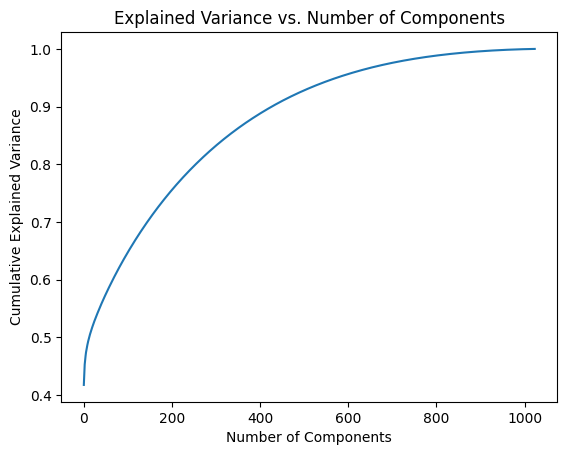

In [6]:
pca = PCA()
pca.fit(Xtest)
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure()
plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.show()

**We want to explain 95 pct. of the variance:**

In [7]:
component_threshold = 0.95
n_components = np.argmax(cumulative_explained_variance >= component_threshold) + 1

print(n_components)

575


**Reduce the dimentions to the number of principal components that explain 0.95 pct. of the variance:**

In [8]:
pca = PCA(n_components=n_components)
pca.fit(X)
pca.fit(Xtest)

X = pca.transform(X)
Xtest = pca.transform(Xtest)

**Split in train/val for hyperparameter search:**

In [9]:
X_reduced, _, y_reduced, _ = train_test_split(X, y, test_size=0.85, random_state=42)

X_train_h, X_val_h, y_train_h, y_val_h = train_test_split(X_reduced, y_reduced, test_size=0.2, random_state=42)

**Create 9 ensambles:**

In [10]:
num_ensembles = 9
samples_per_ensemble = X.shape[0] // num_ensembles

#np.random.seed(42)

for i in range(1, 10):

    indices = np.random.choice(X.shape[0], samples_per_ensemble, replace=False)

    X_subset = X[indices]
    y_subset = y[indices]

    globals()[f'X_{i}'] = X_subset
    globals()[f'y_{i}'] = y_subset

    X = np.delete(X, indices, axis=0)
    y = np.delete(y, indices, axis=0)

**Print the shape of the ensambles:**

In [11]:
for i in range(1,10):
    X = globals()[f'X_{i}']
    y = globals()[f'y_{i}']
    print(X.shape)
    print(y.shape)

(2912, 575)
(2912,)
(2912, 575)
(2912,)
(2912, 575)
(2912,)
(2912, 575)
(2912,)
(2912, 575)
(2912,)
(2912, 575)
(2912,)
(2912, 575)
(2912,)
(2912, 575)
(2912,)
(2912, 575)
(2912,)


**Hyperparameter search SVM:**

In [ ]:

param_grid = ParameterGrid({
    'C': [0.1, 0.25, 0.5, 0.75, 1, 10], })

score_ = 0
params_ = None
for params in param_grid:
  svm_rbf = svm.SVC(kernel='rbf', C=params['C'])
  svm_rbf.fit(X_train_h, y_train_h)
  y_val_hat_rbf = svm_rbf.predict(X_val_h)
  accuracy_rbf = accuracy_score(y_val_hat_rbf, y_val_h)
  if accuracy_rbf > score_:
    score_ = accuracy_rbf
    params_ = params


In [ ]:
print(f"For SVM - using radial and the best hyperparameter C: {params_}, the accuracy of the model is: {accuracy_rbf}")

For SVM - using radial and the best hyperparameter C: {'C': 0.75}, the accuracy of the model is: 0.6963151207115629


**Hyperparameter search RF:**

In [ ]:

param_grid = ParameterGrid({
    'n_estimators': [500, 1000],
    'min_samples_split': [10, 20, 50],
    'min_samples_leaf': [10, 20, 50],
    'max_depth': [None, 300, 200],
    'max_features': ['sqrt', 'log2']
    })

score_ = 0
params_ = None
for params in param_grid:
  rf_current = ensemble.RandomForestClassifier(
                n_estimators=params['n_estimators'],
                min_samples_split=params['min_samples_split'],
                min_samples_leaf=params['min_samples_leaf'],
                max_depth=params['max_depth'],
                max_features=params['max_features'],
                )
  rf_current.fit(X_train_h, y_train_h)
  y_val_hat = rf_current.predict(X_val_h)
  accuracy = accuracy_score(y_val_hat, y_val_h)
  if accuracy > score_:
    score_ = accuracy
    params_ = params


In [ ]:
print(f"For RF the best hyperparameters are: {params_}, the accuracy of the model is: {accuracy}")

For RF the best hyperparameters are: {'max_depth': 300, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 50, 'n_estimators': 500}, the accuracy of the model is: 0.627700127064803


**Hyperparameter search GB:**

In [ ]:

param_grid = ParameterGrid({
    'n_estimators': [500, 1000],
    'min_samples_split': [10, 20, 50],
    'min_samples_leaf': [10, 20, 50],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 0.75],
    })

score_ = 0
params_ = None

for params in param_grid:
  gbt_current = ensemble.GradientBoostingClassifier(
                n_estimators=params['n_estimators'],
                min_samples_split=params['min_samples_split'],
                min_samples_leaf=params['min_samples_leaf'],
                learning_rate=params['learning_rate'],
                )
  gbt_current.fit(X_train_h, y_train_h)
  y_val_hat = gbt_current.predict(X_val_h)
  accuracy = accuracy_score(y_val_hat, y_val_h)
  if accuracy > score_:
    score_ = accuracy
    params_ = params


KeyboardInterrupt: ignored

In [ ]:
print(f"For GB the best hyperparameters are: {params_}, the accuracy of the model is: {accuracy}")

**Initiate the models:**

In [12]:

svm = svm.SVC(kernel='rbf', C=0.75)

rf = ensemble.RandomForestClassifier(
                n_estimators=500,
                min_samples_split=50,
                min_samples_leaf=10,
                max_depth=300,
                max_features='sqrt',
                )

gb = ensemble.GradientBoostingClassifier(
                n_estimators=500,
                min_samples_split=10,
                min_samples_leaf=20,
                learning_rate=0.05,
                )

models = [svm, rf, gb]


In [13]:

df_ensemble = pd.DataFrame(columns=['df1', 'df2', 'df3', 'df4', 'df5', 'df6', 'df7', 'df8', 'df9'])

for i in range(1, 10):

  globals()[f'df{i}'] = pd.DataFrame(columns=['svm', 'rf', 'gb'])

  X = globals()[f'X_{i}']
  y = globals()[f'y_{i}']

  current_df = globals()[f'df{i}']

  column_index = 0

  for model in models:
    z = model.fit(X, y)
    q = z.predict(Xtest)

    column_name = current_df.columns[column_index]
    current_df[column_name] = q
    column_index += 1

def calculate_majority(row):
  counts = pd.Series(row).value_counts()
  majority = counts.idxmax()
  return majority

column_index = 0

for i in range(1, 10):

  d = globals()[f'df{i}']
  d['majority'] = d.apply(calculate_majority, axis=1)

  df_ensemble.iloc[:, column_index] = d['majority']
  column_index += 1

df_ensemble['majority'] = df_ensemble.apply(calculate_majority, axis=1)

<ipython-input-13-b1b798457028>:34: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_ensemble.iloc[:, column_index] = d['majority']
<ipython-input-13-b1b798457028>:34: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_ensemble.iloc[:, column_index] = d['majority']
<ipython-input-13-b1b798457028>:34: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `

**Pred to CSV:**

In [14]:

df_ensemble = pd.DataFrame({
    'Id': range(len(df_ensemble)),
    'Predicted': df_ensemble['majority'].values,
})

path_on_drive = '/content/gdrive/MyDrive/pred.csv'
df_ensemble.to_csv(path_on_drive, index=False)